In [1]:
# So we can import our modules
import sys
sys.path.append("../..")

from src.utils.explainability import visualize_explanation, normalize_attr

import os
import json
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import torch
from ultralytics import YOLO

/nas-ctm01/homes/mjvieira/miniconda3/envs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Analysis of results

In [2]:
df = pd.read_csv("../../results/pornography-2k/cnns/data-aug/even-20/explanations/vgg19_freeze_False_epochs_50_batch_16_optim_sgd_aug_True_split_10_20/correct/IG/faces/results.csv")
df

,frame,box,conf,area,perc,attr
0,vNonPorn000080#17.jpg,NaN,NaN,NaN,NaN,NaN
1,vNonPorn000928#2.jpg,NaN,NaN,NaN,NaN,NaN
2,vPorn000430#15.jpg,NaN,NaN,NaN,NaN,NaN
3,vNonPorn000733#19.jpg,NaN,NaN,NaN,NaN,NaN
4,vPorn000303#10.jpg,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
41344,vNonPorn000956#2.jpg,NaN,NaN,NaN,NaN,NaN
41345,vNonPorn000502#2.jpg,NaN,NaN,NaN,NaN,NaN
41346,vNonPorn000214#5.jpg,NaN,NaN,NaN,NaN,NaN
41347,vNonPorn000037#7.jpg,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41349 entries, 0 to 41348
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   frame   41349 non-null  object 
 1   box     4759 non-null   object 
 2   conf    4759 non-null   float64
 3   area    4759 non-null   float64
 4   perc    4759 non-null   float64
 5   attr    4523 non-null   float64
dtypes: float64(4), object(2)
memory usage: 1.9+ MB


In [4]:
df[(df["attr"] > 50) & df["frame"].str.contains("vPorn")].sort_values(by="attr", ascending=False)

,frame,box,conf,area,perc,attr
29311,vPorn000768#16.jpg,"(190.0, 0.0, 223.0, 52.0)",0.76166,1716.0,3.419962,88.804434
33732,vPorn000885#16.jpg,"(79.0, 1.0, 134.0, 87.0)",0.51067,4730.0,9.426818,81.698442
6628,vPorn000564#4.jpg,"(121.0, 1.0, 179.0, 122.0)",0.87614,7018.0,13.986767,75.190691
20088,vPorn000055#7.jpg,"(120.0, 1.0, 141.0, 24.0)",0.78152,483.0,0.962612,68.175146
28384,vPorn000569#1.jpg,"(33.0, 1.0, 136.0, 124.0)",0.51997,12669.0,25.249123,64.585635
1873,vPorn000174#15.jpg,"(99.0, 0.0, 172.0, 69.0)",0.70649,5037.0,10.038664,57.560490
30086,vPorn000564#12.jpg,"(87.0, 1.0, 146.0, 106.0)",0.84653,6195.0,12.346540,56.575445
19593,vPorn000923#3.jpg,"(68.0, 1.0, 176.0, 135.0)",0.81045,14472.0,28.842474,56.285079
40968,vPorn000180#8.jpg,"(87.0, 1.0, 167.0, 103.0)",0.85315,8160.0,16.262755,56.158612
25702,vPorn000519#0.jpg,"(10.0, 0.0, 124.0, 151.0)",0.55048,17214.0,34.307239,54.396578


### Privacy-preserving explanations

In [2]:
DATA_LOC = "/nas-ctm01/datasets/public/BIOMETRICS/pornography-2k-db/data-processed/even-20"
FACES_LOC = "/nas-ctm01/datasets/public/BIOMETRICS/pornography-2k-db/data-processed/even-20-detected-faces"
EXPLANATIONS_LOC = "../../results/pornography-2k/cnns/data-aug/even-20/explanations/vgg19_freeze_False_epochs_50_batch_16_optim_sgd_aug_True_split_10_20/correct/IG/npys"
# EXPLANATIONS_LOC = "../../results/pornography-2k/transformers/no-freeze/even-20/explanations/vit_base_patch16_224_epochs_50_batch_16_optim_sgd_aug_False_split_10_20/correct/npys"

In [4]:
CHW = lambda shape: shape[0] in (3, 4)
HWC = lambda input: np.transpose(input, (1, 2, 0))

def calculate_attribution_in_box(attr, box_coords):
    x1, y1, x2, y2 = box_coords
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    reduction_axis = None
    if attr.ndim == 3:
        reduction_axis = 0 if CHW(attr.shape) else 2

    abs_attr = normalize_attr(attr, sign="absolute_value", reduction_axis=reduction_axis)
    pos_attr = neg_attr = None

    # If there are only positive attribution values, it is not possible to calculate neg_attr 
    # Also, there is no need to calculate pos_attr because it will be equal to abs_attr
    if attr.min() < 0.0:
        pos_attr = normalize_attr(attr=attr, sign="positive", reduction_axis=reduction_axis)
        neg_attr = normalize_attr(attr=attr, sign="negative", reduction_axis=reduction_axis)

    total_attr = np.sum(abs_attr)
    total_box_attr = np.sum(abs_attr[y1:y2, x1:x2])
    perc_attr = (total_box_attr / total_attr) * 100
    
    perc_pos_attr = perc_neg_attr = None
    if pos_attr is not None:
        total_pos_attr = np.sum(pos_attr)
        total_box_pos_attr = np.sum(pos_attr[y1:y2, x1:x2])
        perc_pos_attr = (total_box_pos_attr / total_pos_attr) * 100
    if neg_attr is not None:
        total_neg_attr = np.sum(neg_attr)
        total_box_neg_attr = np.sum(neg_attr[y1:y2, x1:x2])
        perc_neg_attr = (total_box_neg_attr / total_neg_attr) * 100

    return perc_attr, perc_pos_attr, perc_neg_attr


def blur_box(image, box_coords):
    x1, y1, x2, y2 = box_coords
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    roi = image[y1:y2, x1:x2]
    if len(roi) == 0: return
    KSIZE, SIGMA = (9, 9), 15
    roi = cv2.GaussianBlur(roi, KSIZE, SIGMA)

    image[y1:y2, x1:x2] = roi


def show_blurred_explanation(image, attr):
    visualize_explanation(
        image=image,
        attr=attr,
        colormap="jet",
        side_by_side=True,
        sign="positive",
        show_colorbar=True,
    ).show()

In [5]:
CONF_THRES = 0.6
model = YOLO(model="../../yolov8n-face.pt")

In [6]:
INPUT_SHAPE = 224
H = W = INPUT_SHAPE
IMG_AREA = H * W

data_transforms = A.Resize(height=H, width=W)

In [13]:
def generate_privacy_preserving_explanation(img_name):
    print("YOLO face detection with explanation anonymization")

    result = model.predict(source=f"{DATA_LOC}/{img_name}", conf=CONF_THRES)[0]
    result.show()

    # load original image
    img_file = os.path.join(DATA_LOC, img_name)
    assert os.path.isfile(img_file), "Invalid image path"

    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h_orig, w_orig, _ = img.shape
    print("Image original shape:", img.shape)

    img = data_transforms(image=img)["image"]
    print("Transformed image shape:", img.shape)

    # load explanation
    attr_file = os.path.join(EXPLANATIONS_LOC, os.path.splitext(img_name)[0] + ".npy")
    assert os.path.isfile(attr_file), "Invalid explanation path"

    attr_np = np.load(attr_file)
    print("Attribution shape:", attr_np.shape)

    h_ratio, w_ratio = H / h_orig, W / w_orig

    adjusted_boxes = torch.clone(result.boxes.data)
    adjusted_boxes[:, 0] = torch.round(adjusted_boxes[:, 0] * w_ratio)
    adjusted_boxes[:, 1] = torch.round(adjusted_boxes[:, 1] * h_ratio)
    adjusted_boxes[:, 2] = torch.round(adjusted_boxes[:, 2] * w_ratio)
    adjusted_boxes[:, 3] = torch.round(adjusted_boxes[:, 3] * h_ratio)
    result.update(boxes=adjusted_boxes)
    print("\nResult (x1, y1, x2, y2, conf, cls):\n", result.boxes.data, "\n")

    # Print also json for comparison
    # with open(f"{FACES_LOC}/{img_name[:-4]}.json", "r") as infile:
    #     faces_json = json.load(infile)
    #     print(json.dumps(faces_json, indent=2))

    for box in result.boxes.data:
        x1, y1, x2, y2, conf, _ = box
        area = (x2 - x1) * (y2 - y1)
        perc = (area / IMG_AREA) * 100
        attr, pos_attr, neg_attr = calculate_attribution_in_box(attr_np, (x1, y1, x2, y2))

        if area != 0:
            blur_box(img, (x1, y1, x2, y2))
        
        info = (
            f"Confidence: {conf.item():.3f} | "
            f"Area: {area.item()} | "
            f"Perc (%): {perc.item():.3f}\n"
            f"Total attr (%): {attr:.3f}"
        )
        if pos_attr is not None: info += f" | Positive attr (%): {pos_attr:.3f}"
        if neg_attr is not None: info += f" | Negative attr (%): {neg_attr:.3f}"
        print(info + "\n")

    show_blurred_explanation(img, attr_np)

YOLO face detection with explanation anonymization

image 1/1 /nas-ctm01/datasets/public/BIOMETRICS/pornography-2k-db/data-processed/even-20/vPorn000564#4.jpg: 384x640 2 faces, 114.3ms
Speed: 2.2ms preprocess, 114.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


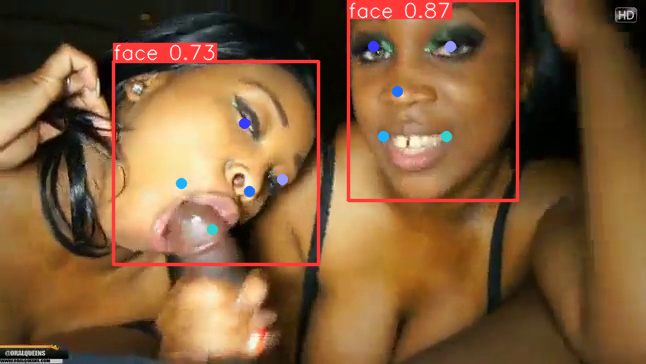

Image original shape: (364, 646, 3)
Transformed image shape: (224, 224, 3)
Attribution shape: (3, 224, 224)

Result (x1, y1, x2, y2, conf, cls):
 tensor([[121.0000,   0.0000, 179.0000, 123.0000,   0.8700,   0.0000],
        [ 39.0000,  38.0000, 110.0000, 162.0000,   0.7314,   0.0000]]) 

Confidence: 0.870 | Area: 7134.0 | Perc (%): 14.218
Total attr (%): 12.433 | Positive attr (%): 12.279 | Negative attr (%): 12.589

Confidence: 0.731 | Area: 8804.0 | Perc (%): 17.546
Total attr (%): 23.928 | Positive attr (%): 24.003 | Negative attr (%): 23.834



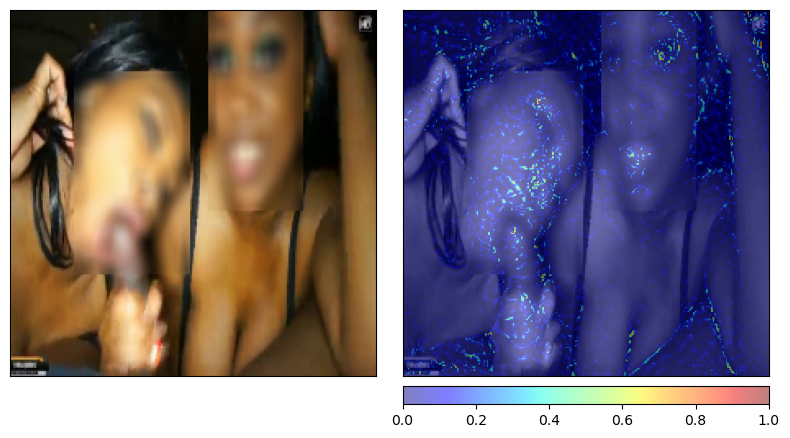

In [15]:
generate_privacy_preserving_explanation("vPorn000564#4.jpg")